In [1]:
import pandas as pd
import mercantile
from shapely.geometry import box
import geopandas as gpd
from concurrent.futures import ThreadPoolExecutor, as_completed
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import rasterio
from rasterstats import zonal_stats
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
import os
from shapely import Point

In [2]:
path_data = '/home/sol/gitrepo/MENA-FCV-economic-monitor/data/'
zoom = 12
net_type = 'fixed'

In [3]:
iso_codes = [
    "afg", "are", "bhr", "dji", "dza", "egy", "irn", "irq", "jor", "kwt",
    "lbn", "lby", "mar", "omn", "pak", "pse", "qat", "sau", "syr", "tun", "yem"]
iso_codes = [x.upper() for x in iso_codes]

## Detection of areas of interest
As we analyze the change in the Weighted Average Download Speed (WADS) there are some countries that call our attention.
In order to understand these changes, the following plots show the contribution of each tile to increase the Weighted Average Download Speed. Instead of just showing the average speed at each tile, we are showing the average speed times the population from that tile and divide that by the population of the country.

$$
\text{Share of WADS}_{i} = \frac{WADS_{i} * Population_{i}}{\sum_{i=1}^{m}Population_{i}}
$$

In [4]:
countries_gdf = {}
for iso_code in iso_codes:
    gdf=gpd.read_file(f'../results/gdf_{iso_code}_with_variables.gpkg')
    gdf.set_index('index', inplace = True)
    countries_gdf[iso_code] = gdf

In [5]:
def calculate_shares(d):
    for col in d.columns:
        if (col == 'population') or (col.startswith('share')) or col == 'geometry':
            continue
        else:
            d['share_' + col] = (d[col]*d['population'])/sum(d.population)
    return d

### PSE
It is classified in the Mid level group. We observed a decline in the WADS during 2023-Q4 aligned with the start of the war and a recover in 2024-Q4. By plotting the spatial distribution of the data, we observe that there is no data for Gaza in 2025. 
Gaza has a good amout of data in the first 3 quarters of 2019. After that, most of its tiles do not have data. In 2025, there is data for one of the tiles in the south shown below. 

**Share of Weighted Average Download Speed in Q2 2025 for Palestine**

In [42]:
pse = calculate_shares(countries_gdf['PSE'])
pse[['geometry', 'avg_download_2025_2', 'share_avg_download_2025_2']].explore(column = 'share_avg_download_2025_2')

**Share of Weighted Average Download Speed in Q1 2019 for Gaza**

In [71]:
gaza = ['1200','1203','1202', '1220', '0313', '0331', '0330', '0323', '0332', '0333', '2101', '2110', '2111', '2103', '2112']
gaza = ['12213000'+x for x in gaza]
gaza_with_data = ['122130002103']

In [75]:
pse.loc[gaza].explore(column = 'avg_download_2019_1')

**Polygon with available data in Q2 2024 for Gaza**

In [72]:
pse.loc[gaza_with_data].explore(column = 'avg_download_2024_2')

### LBN
We obseve an uptake in Q4 2023 that grows till Q2 2024. In Q3 and Q4 2023 it decreases a gain and stays stable till Q2 2025.
When observing the distribution of the share of WADS, we conclude that these changes are mostly due to changes that occured in Beirut. 

In [12]:
lbn = calculate_shares(countries_gdf['LBN'])

**Share of Weighted Average Download Speed in Q4 2023 for Lebanon**

In [13]:
lbn.explore('share_avg_download_2023_4')

In [43]:
def plot_map(gdf, col, boundary, ax, title, vmin, vmax):
    boundary.boundary.plot(ax=ax, edgecolor="#D3D3D3", linewidth=0.5)
    im = gdf.plot(
            column=col,
            ax=ax,
            legend=True,
            cmap="Spectral",
            vmin = vmin,
            vmax = vmax
        )
    ax.set_title(f"{title}")

    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    leg = ax.get_legend()
    if leg is not None:
        leg.set_title("Mbps")

In [37]:
vmax = lbn[['share_avg_download_2023_4', 'share_avg_download_2024_1', 'share_avg_download_2024_2', 'share_avg_download_2024_3', 'share_avg_download_2024_4']].max().max()
vmin = lbn[['share_avg_download_2023_4', 'share_avg_download_2024_1', 'share_avg_download_2024_2', 'share_avg_download_2024_3', 'share_avg_download_2024_4']].min().min()

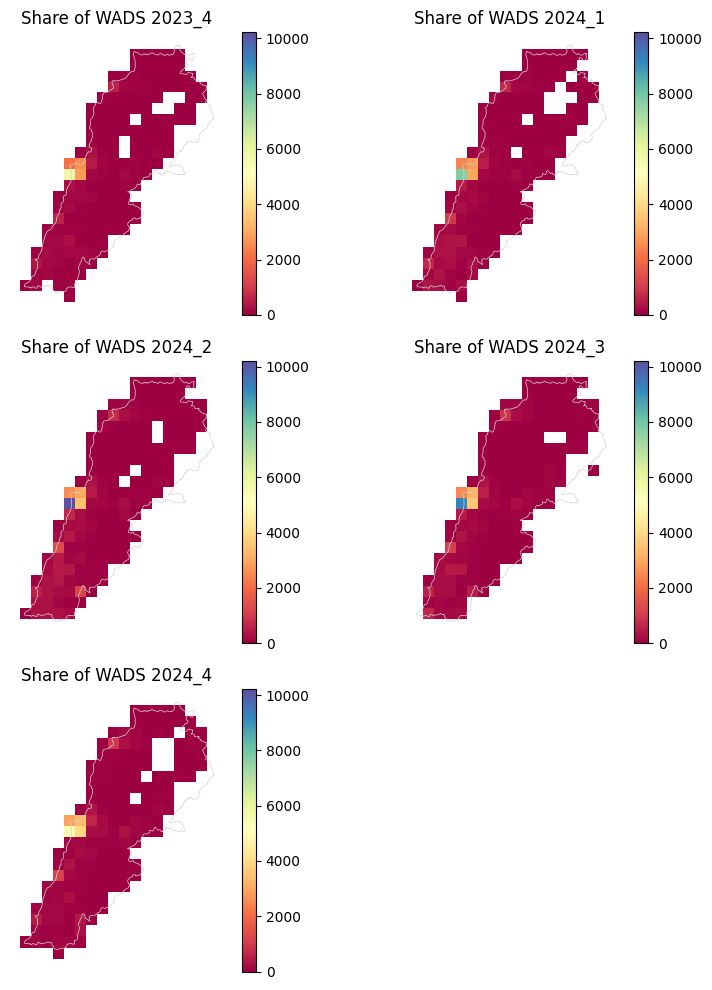

In [42]:
fig, ax = plt.subplots(3, 2, figsize=(8, 10), sharex=True, sharey=True)
ax = ax.flatten()
i = 0
boundary = gpd.read_file(path_data + f'admin_boundaries/LBN_ADM0_gbOpen.geojson')
for col in ['2023_4', '2024_1', '2024_2', '2024_3', '2024_4']:
    plot_map(lbn, 'share_avg_download_' + col, boundary, ax[i], 'Share of WADS '+col, vmin, vmax)
    plt.tight_layout()
    i +=1
ax[5].set_visible(False)

### Syr
Syria has been growing since Q3 2023. Althought there was a decrease from Q1 to Q2 in 2025, more information is needed to confirm this trend

In [46]:
syr = calculate_shares(countries_gdf['SYR'])

**Share of Weighted Average Download Speed in Q2 2025 for Syria**

In [48]:
syr[['share_avg_download_2025_1', 'share_avg_download_2025_2', 'geometry']].explore('share_avg_download_2025_2')

### AFG
Afghanistan has been growing since Q1 2023. 

In [50]:
afg = calculate_shares(countries_gdf['AFG'])

**Share of Weighted Average Download Speed in Q2 2025 for Afghanistan**

In [51]:
afg[['share_avg_download_2025_1', 'share_avg_download_2025_2', 'geometry']].explore('share_avg_download_2025_2')